<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-and-vision-practices/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.8.0
1.21.6
1.3.5


#Load Dataset

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

print(type(x_train))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>
(60000, 28, 28)
(10000, 28, 28)


#Basic Autoencoder

In [7]:
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.laten_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0237 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.008

In [10]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

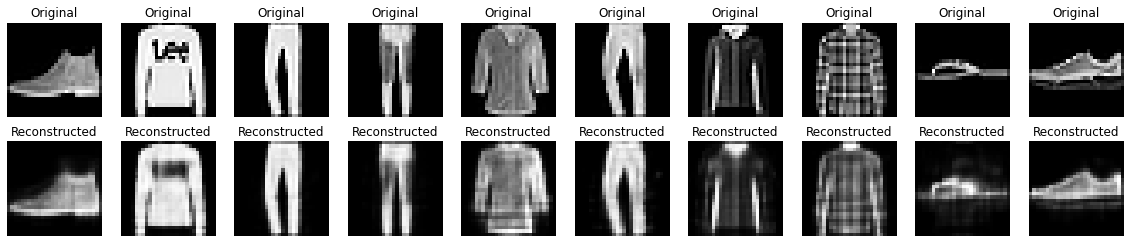

In [11]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    plt.axis('off')

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    plt.axis('off')

plt.show()

#Image denoising

In [12]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [13]:
# Adding random noise
noise_factor = 0.2
x_train_noisy = tf.clip_by_value(x_train+noise_factor*tf.random.normal(shape=x_train.shape), clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test+noise_factor*tf.random.normal(shape=x_test.shape), clip_value_min=0., clip_value_max=1.)

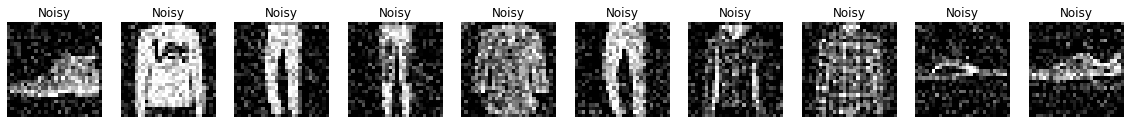

In [18]:
# Plot noisy images
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i], -1))
    plt.title('Noisy')
    plt.gray()
    plt.axis('off')
plt.show()

#Define a convolutional Autoencoder

In [21]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, padding='same', strides=2, activation='relu'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [22]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(
    x_train_noisy, x_train, epochs=10, shuffle=True, 
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
1875/1875 [==============================] - 84s 44ms/step - loss: 0.0171 - val_loss: 0.0104
Epoch 2/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 3/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 4/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 5/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 7/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 8/10
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 10/10
1875/1875 [==============================] - 89s 48m

In [23]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Plotting both noisy and denoised images
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
denoised_imgs = autoencoder.decoder(encoded_imgs).numpy()

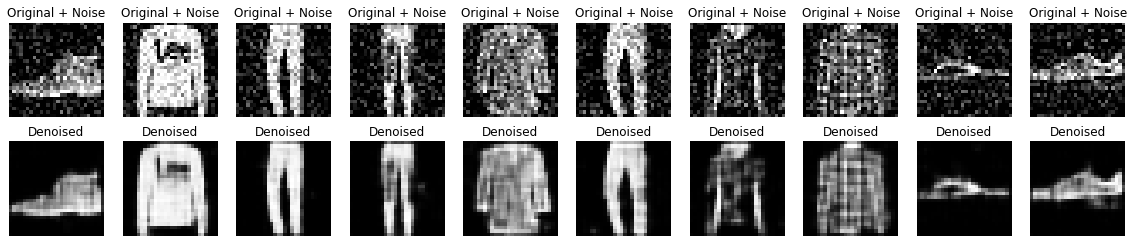

In [27]:
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("Original + Noise")
    plt.gray()
    plt.axis('off')

    plt.subplot(2, n, i+1+n)
    plt.imshow(tf.squeeze(denoised_imgs[i]))
    plt.title("Denoised")
    plt.gray()
    plt.axis('off')

plt.show()

#Anomaly detection

In [29]:
# Download dataset
dataframe = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [32]:
dataframe.shape

(4998, 141)

In [30]:
# The last element contaoins the labels
labels = raw_data[:, -1]

# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Normalize the data to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

print(np.min(train_data), np.max(train_data))
print(np.min(test_data), np.max(test_data))
print(train_data.dtype)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

0.0 1.0
-0.0591610161363773 0.821991320413042
<dtype: 'float64'>


In [35]:
print("Total train samples:", len(train_data))
print("Total test samples:", len(test_data))

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

abnormal_train_data = train_data[~train_labels]
abnormal_test_data = test_data[~test_labels]

print("Normal train samples:", len(normal_train_data))
print("Normal test samples:", len(normal_test_data))
print("Abnormal train samples:", len(abnormal_train_data))
print("Abnormal test samples:", len(abnormal_test_data))

Total train samples: 3998
Total test samples: 1000
Normal train samples: 2359
Normal test samples: 560
Abnormal train samples: 1639
Abnormal test samples: 440


#Plot a normal ECG

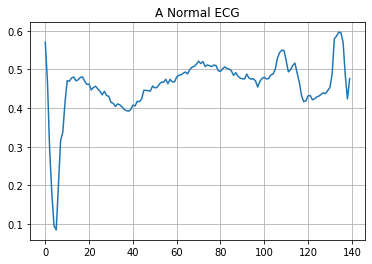

In [36]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

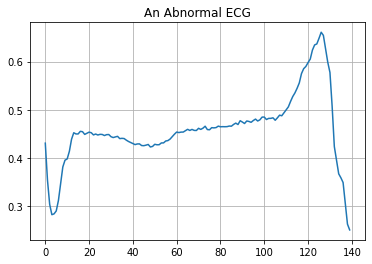

In [37]:
plt.plot(np.arange(140), abnormal_train_data[0])
plt.title("An Abnormal ECG")
plt.grid()
plt.show()

In [38]:
class AnomalyDetector(Model):
    """Anomaly detector of electrocardiogram."""
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.models.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])

        self.decoder = tf.keras.models.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded 

In [39]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs=20,
    batch_size=512,
    validation_data=(test_data, test_data),
    shuffle=True
)

Epoch 1/20
5/5 [==============================] - 3s 96ms/step - loss: 0.0578 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0557 - val_loss: 0.0514
Epoch 3/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0527 - val_loss: 0.0497
Epoch 4/20
5/5 [==============================] - 0s 34ms/step - loss: 0.0489 - val_loss: 0.0483
Epoch 5/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0446 - val_loss: 0.0464
Epoch 6/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0405 - val_loss: 0.0438
Epoch 7/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0367 - val_loss: 0.0419
Epoch 8/20
5/5 [==============================] - 0s 28ms/step - loss: 0.0335 - val_loss: 0.0404
Epoch 9/20
5/5 [==============================] - 0s 28ms/step - loss: 0.0309 - val_loss: 0.0390
Epoch 10/20
5/5 [==============================] - 0s 32ms/step - loss: 0.0289 - val_loss: 0.0380
Epoch 11/20
5/5 [============

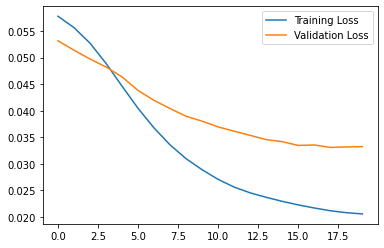

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

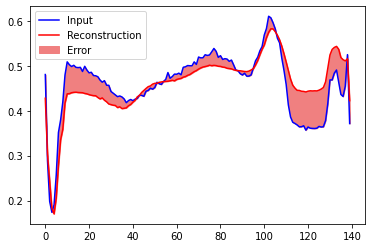

In [42]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

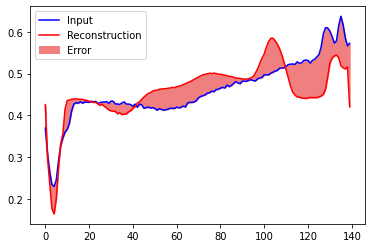

In [44]:
encoded_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(abnormal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], abnormal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

#Detect Anomalies

(2359,)


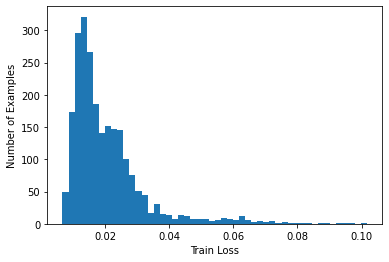

In [45]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(normal_train_data, reconstructions)
print(train_loss.shape)
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train Loss")
plt.ylabel("Number of Examples")
plt.show()

In [47]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:   ", threshold)


Threshold:    0.03256851


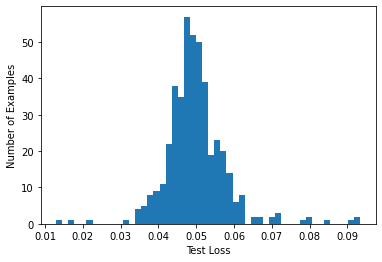

In [48]:
reconstructions = autoencoder.predict(abnormal_test_data)
test_loss = tf.keras.losses.mae(abnormal_test_data, reconstructions)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel('Test Loss')
plt.ylabel("Number of Examples")
plt.show()


#Classify an ECG

In [52]:
def predict(model, data, threshold):
    """Predicts if the data is normal rythm."""
    reconstruction = model(data)
    loss = tf.keras.losses.mae(data, reconstruction)
    return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    

In [53]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.946
Precision = 0.9922178988326849
Recall = 0.9107142857142857
